### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data
https://www.kaggle.com/datasets/surajjha101/cuisine-rating

---
##### Data Dictionary

    User ID - User ID of customers
    Area code - Area code of customers residence
    Location - Area and the city of residence of customers
    Gender - Gender of customer
    YOB - Year when customer was born
    Marital Status - Marital status
    Activity - Customers career status whether student or professional
    Budget - Budget they may spend in the restaurant
    Cuisines - Cuisine they preferred/liked the most to have at restaurant
    Alcohol - Alcohol intake frequency
    Food Rating - Rating they gave to restaurant's food
    Service Rating - Rating they gave to restaurant's service
    Overall Rating - Mean rating calculated from food and service ratings
    Often A S - Often they visited restaurant or not
---

In [2]:
df = pd.read_csv("../../DATA/kaggle/cuisine_rating.csv")
df.head()

,User ID,Area code,Location,Gender,YOB,Marital Status,Activity,Budget,Cuisines,Alcohol,Smoker,Food Rating,Service Rating,Overall Rating,Often A S
0,1,153,"Upper East Side,NY",Female,2006,Single,Professional,3,Japanese,Never,Never,5,4,4.5,No
1,2,123,"St. George,NY",Female,1991,Married,Student,3,Indian,Never,Socially,1,1,1.0,No
2,3,122,"Upper West Side,NY",Male,1977,Single,Student,5,Seafood,Often,Often,5,5,5.0,Yes
3,4,153,"Upper East Side,NY",Female,1956,Married,Professional,5,Japanese,Never,Socially,3,1,2.0,No
4,5,129,"Central Park,NY",Male,1997,Single,Student,4,Filipino,Socially,Never,2,4,3.0,No


## Goal definition
**What rating does a cuisine dish get?**\
\
The problem refers to regression, that is, to predict the numerical value of an Food Rating.

## Exploratory Data Analysis and Visualisations - IMPORTANT NOTE!
Full EDA process was performed in another file (*EDA_cuisine_raring.ipynb*), so here that process is skipped. The file is located in the same repository in the *Projects/EDA* folder. This section applies only to additional visualizations for problem solving.

#### Budget impact on food rating

<Axes: xlabel='Food Rating', ylabel='Budget'>

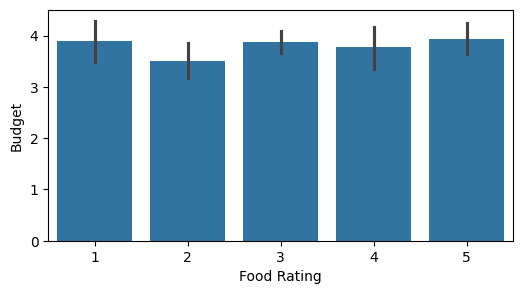

In [3]:
plt.figure(figsize=(6,3))
sns.barplot(data=df, x='Food Rating', y='Budget')

##### Conclusions
Budget does not have much impact on the food rating

## Modeling

### Data preparation

In [4]:
df_dummies = pd.get_dummies(df, drop_first=True)

### Train | Test Split

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X = df_dummies.drop('Food Rating', axis=1)
y = df_dummies['Food Rating']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

## Random Forest Model

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [9]:
rfr_model = RandomForestRegressor(bootstrap=True, oob_score=True)

In [10]:
n_estimators = [50,100,150]
param_grid = {'n_estimators': n_estimators}

In [11]:
grid_model = GridSearchCV(rfr_model, param_grid)

In [12]:
grid_model.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(oob_score=True),
             param_grid={'n_estimators': [50, 100, 150]})

In [13]:
grid_model.best_params_

{'n_estimators': 100}

### Evaluation

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

In [15]:
y_pred = grid_model.predict(X_test)

In [16]:
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = root_mean_squared_error(y_test, y_pred)

In [17]:
print(MAE, MSE, RMSE)

0.12899999999999995 0.02983499999999998 0.1727281100458173


#### Residuals

In [18]:
test_residuals = y_test - y_pred

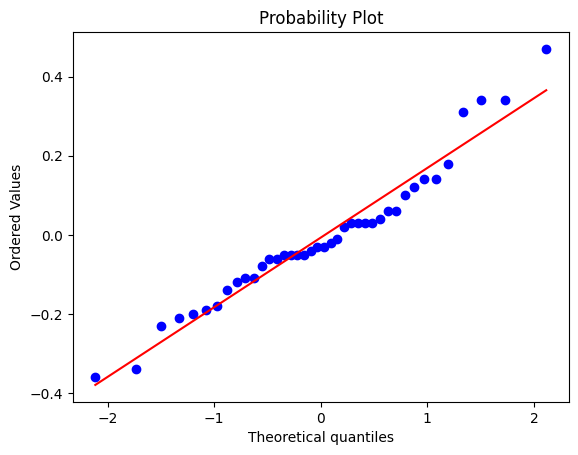

In [21]:
import scipy as sp
fig, ax = plt.subplots()
_ = sp.stats.probplot(test_residuals, plot=ax)

## 